In [1]:
%matplotlib inline
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import numpy as np 

In [2]:
class CPPINN(nn.Module):
    features: Sequence[int]
 
    #bases = [bases_x,bases_y,bases_z]
    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            
            outputs += [jnp.transpose(X, (1, 0))]

        xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
        return jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
    
class TTPINN(nn.Module):
    features: Sequence[int]
 
    #bases = [bases_x,bases_y,bases_z]
    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_uniform()
        for i,X in enumerate(inputs):
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            if i==0:
                X = nn.DenseGeneral((self.features[-1],self.features[-1]), kernel_init=init)(X)
                
            else:
                X = nn.Dense(self.features[-1], kernel_init=init)(X)
            outputs += [X]
                
        #mid = jnp.einsum('ij,kj->ikj', outputs[1][:self.features[-1]], outputs[1][self.features[-1]:])
        #print(mid.shape)
        #mid = jnp.einsum('fx,ky->fyk',outputs[0],outputs[1])
        #xyz = jnp.einsum('fx, fy,fz->xyz', outputs[0], outputs[1],outputs[-1])
        return jnp.einsum('xfk,yf,zk->xyz',outputs[0],outputs[1],outputs[-1])

    
class TuckerPINN(nn.Module):
    features: Sequence[int]
 
    def setup(self):
        # Initialize learnable parameters
        #self.centres = self.param('centres', nn.initializers.uniform(1.01), (self.out_features, 1))
        self.core = self.param("core",nn.initializers.orthogonal(),(self.features[-1],self.features[-1],self.features[-1]))

    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            
            outputs += [jnp.transpose(X, (1, 0))]
            #mid = jnp.einsum("fx,fy->fxy",outputs[0],outputs[1])
        return jnp.einsum("klm,kx,ly,mz->xyz",self.core,outputs[0],outputs[1],outputs[-1])
    
    

In [3]:
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out

In [4]:
def relative_l2(u, u_gt):
    return jnp.linalg.norm(u-u_gt) / jnp.linalg.norm(u_gt)

In [5]:
def loss_flowmixer(apply_fn,  *train_data):
    def residual_loss(params, t, x, y, a, b):
        # tangent vector dx/dx
        v_t = jnp.ones(t.shape)
        v_x = jnp.ones(x.shape)
        v_y = jnp.ones(y.shape)
        # 1st derivatives of u
        ut = jvp(lambda t: apply_fn(params, t, x, y), (t,), (v_t,))[1]
        ux = jvp(lambda x: apply_fn(params, t, x, y), (x,), (v_x,))[1]
        uy = jvp(lambda y: apply_fn(params, t, x, y), (y,), (v_y,))[1]
        return jnp.mean((ut + a*ux + b*uy)**2)

    def initial_loss(params, t, x, y, u):
        return jnp.mean((apply_fn(params, t, x, y) - u)**2)

    def boundary_loss(params, t, x, y, u):
        loss = 0.
        for i in range(4):
            loss += jnp.mean((apply_fn(params, t[i], x[i], y[i]) - u[i])**2)
        return loss

    # unpack data
    print("Received",len(train_data))

    tc, xc, yc, ti, xi, yi, ui, tb, xb, yb, ub, a, b = train_data

    # isolate loss func from redundant arguments
    loss_fn = lambda params: 10*residual_loss(params, tc, xc, yc, a, b) + \
                        initial_loss(params, ti, xi, yi, ui) + \
                        boundary_loss(params, tb, xb, yb, ub)

    #loss, gradient = jax.value_and_grad(loss_fn)(params)

    return loss_fn

In [6]:
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [7]:
def flow_mixing3d_exact_u(t, x, y, omega):
    return -jnp.tanh((y/2)*jnp.cos(omega*t) - (x/2)*jnp.sin(omega*t))


# 3d time-dependent flow-mixing parameters
def flow_mixing3d_params(t, x, y, v_max = 0.385,require_ab=False):
    
    # t, x, y must be meshgrid
    r = jnp.sqrt(x**2 + y**2)
    v_t = ((1/jnp.cosh(r))**2) * jnp.tanh(r)
    omega = (1/r)*(v_t/v_max)
    a, b = None, None
    if require_ab:
        a = -(v_t/v_max)*(y/r)
        b = (v_t/v_max)*(x/r)
    return omega, a, b


def train_generator_flow_mixing3d(nc,key):
    v_max = 0.385
    keys = jax.random.split(key, 3)
    # collocation points
    tc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=4.)
    xc = jax.random.uniform(keys[1], (nc, 1), minval=-4., maxval=4.)
    yc = jax.random.uniform(keys[2], (nc, 1), minval=-4., maxval=4.)
    tc_mesh, xc_mesh, yc_mesh = jnp.meshgrid(tc.ravel(), xc.ravel(), yc.ravel(), indexing='ij')

    _, a, b = flow_mixing3d_params(tc_mesh, xc_mesh, yc_mesh, v_max=0.385, require_ab=True)

    # initial points
    ti = jnp.zeros((1, 1))
    xi = xc
    yi = yc
    ti_mesh, xi_mesh, yi_mesh = jnp.meshgrid(ti.ravel(), xi.ravel(), yi.ravel(), indexing='ij')
    omega_i, _, _ = flow_mixing3d_params(ti_mesh, xi_mesh, yi_mesh, v_max=0.385)
    ui = flow_mixing3d_exact_u(ti_mesh, xi_mesh, yi_mesh, omega_i)
    # boundary points (hard-coded)
    tb = [tc, tc, tc, tc]
    xb = [jnp.array([[-4.]]), jnp.array([[4.]]), xc, xc]
    yb = [yc, yc, jnp.array([[-4.]]), jnp.array([[4.]])]
    ub = []
    for i in range(4):
        tb_mesh, xb_mesh, yb_mesh = jnp.meshgrid(tb[i].ravel(), xb[i].ravel(), yb[i].ravel(), indexing='ij')
        omega_b, _, _ = flow_mixing3d_params(tb_mesh, xb_mesh, yb_mesh, v_max=0.385)
        ub += [flow_mixing3d_exact_u(tb_mesh, xb_mesh, yb_mesh, omega_b)]
    return tc, xc, yc, ti, xi, yi, ui, tb, xb, yb, ub, a, b

In [8]:
def test_generator_flow_mixing3d(nc_test):
    v_max = 0.385
    t = jnp.linspace(0, 4, nc_test)
    x = jnp.linspace(-4, 4, nc_test)
    y = jnp.linspace(-4, 4, nc_test)
    t = jax.lax.stop_gradient(t)
    x = jax.lax.stop_gradient(x)
    y = jax.lax.stop_gradient(y)
    tm, xm, ym = jnp.meshgrid(t, x, y, indexing='ij')

    omega, _, _ = flow_mixing3d_params(tm, xm, ym, v_max)
    u_gt = flow_mixing3d_exact_u(tm, xm, ym, omega)
    t = t.reshape(-1, 1)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    return t, x, y,tm,xm,ym ,u_gt

In [9]:
def plotter(xm,ym,zm,u):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    im = ax.scatter(xm,ym,zm, c=u, s=0.5, cmap='magma')
    ax.set_title('U(t, x, y)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    fig.colorbar(im,ax=ax)
    plt.show()

In [ ]:
def main(mode,NC, NI, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER):
    # force jax to use one device
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

    # random key
    key = jax.random.PRNGKey(SEED)
    key, subkey = jax.random.split(key, 2)

    # feature sizes
    feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))

    #model = RBFPINN(FEATURES,linear)
    # make & init model
    if mode == "CPPINN":
        model = CPPINN(feat_sizes)
    elif mode == "TTPINN":
        model = TTPINN(feat_sizes)
    elif mode == "TuckerPINN":
        model = TuckerPINN(feat_sizes)
    params = model.init(subkey, jax.random.uniform(key,(NC, 1)), jax.random.uniform(key,(NC, 1)), jax.random.uniform(key,(NC, 1)))
    # optimizer
    optim = optax.adam(LR)
    state = optim.init(params)

    # dataset
    key, subkey = jax.random.split(key, 2)
    train_data = train_generator_flow_mixing3d(NC, subkey)
    print(len(train_data))
    #x, y, z, xm,ym,zm,u_gt = _test_generator_helmholtz3d(4,4,3,NC_TEST)
    t,x,y,tm,xm,ym, u_gt = test_generator_flow_mixing3d(NC_TEST)
    #print(t,x,y)
    logger =[]

    # forward & loss function
    apply_fn = jax.jit(model.apply)
    #print(len(*train_data))
    loss_fn = loss_flowmixer(apply_fn, *train_data)

    @jax.jit
    def train_one_step(params, state):
        # compute loss and gradient
        loss, gradient = value_and_grad(loss_fn)(params)
        # update state
        params, state = update_model(optim, gradient, params, state)
        return loss, params, state
    
    start = time.time()
    for e in trange(1, EPOCHS+1):
        # single run
        loss, params, state = train_one_step(params, state)
        if e % LOG_ITER == 0 or e == 1:
            u = apply_fn(params, t,x,y)
            error = relative_l2(u, u_gt)
            print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}, error: {error:.8f}')
            logger.append([e,loss,error])
            #print('Solution:')
            #u = apply_fn(params,t,x,y)
            #plotter(tm,xm,ym,u)
        
    end = time.time()
    print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

    #print('Solution:')
    #u = apply_fn(params,t,x,y)
    #plotter(tm,xm,ym,u)
    return logger

In [ ]:
num = 128
for model in ["TuckerPINN"]: 
    for rank in [64,128]:
        for run in range(10):
            logs = main(mode=model,NC=num, NI=num, NB=num, NC_TEST=128, SEED=444+run, LR=1e-3, EPOCHS=80000, N_LAYERS=4, FEATURES=rank, LOG_ITER=5000)
            logs = np.array(logs)
            if np.min(logs[:,2])< 0.1:
                np.savetxt("Rank{}/model_{}_run_{}".format(rank,model,run),logs)

In [10]:
t, x, y,tm,xm,ym ,u_gt= test_generator_flow_mixing3d(100)

2024-06-24 10:40:44.803880: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
fig,ax = plt.subplots(2,2,figsize=(6,6))
im=ax[0,0].imshow(u_gt[0,:,:].T,cmap='magma',extent=[-4,4,-4,4])
ax[0,0].set_title("t=0",fontsize=8)
ax[0,0].tick_params(axis='x', labelsize=8)
ax[0,0].tick_params(axis='y', labelsize=8)

ax[0,1].imshow(u_gt[50,:,:].T,cmap='magma',extent=[-4,4,-4,4])
ax[0,1].set_title("t=2",fontsize=8)
ax[0,1].tick_params(axis='x', labelsize=8)
ax[0,1].tick_params(axis='y', labelsize=8)

ax[1,0].imshow(u_gt[75,:,:].T,cmap='magma',extent=[-4,4,-4,4])
ax[1,0].set_title("t=3",fontsize=8)
ax[1,0].tick_params(axis='x', labelsize=8)
ax[1,0].tick_params(axis='y', labelsize=8)

ax[1,1].imshow(u_gt[-1,:,:].T,cmap='magma',extent=[-4,4,-4,4])
ax[1,1].set_title("t=4",fontsize=8)
ax[1,1].tick_params(axis='x', labelsize=8)
ax[1,1].tick_params(axis='y', labelsize=8)

fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)

In [ ]:
from celluloid import Camera

In [ ]:
fig = plt.figure()
camera = Camera(fig)

NameError: name 'camera' is not defined

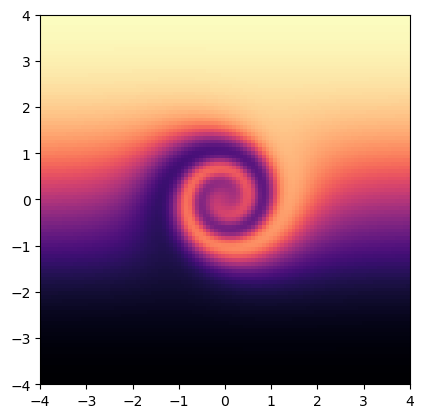

In [11]:
for i in range(20):
    k = i*5 
    plt.imshow(u_gt[k,:,:].T,cmap='magma',extent=[-4,4,-4,4])
    #plt.show()
    plt.savefig("snaps/snap{}".format(i))
    #camera.snap()
plt.imshow(u_gt[-1,:,:].T,cmap='magma', extent=[-4,4,-4,4])
plt.savefig("snaps/snap20".format(i))
#camera.snap()

In [ ]:
animation = camera.animate()


In [ ]:
animation

In [ ]:
#writergif = animation.PillowWriter(fps=30)
animation.save('flow.gif',writer='imagemagick')